In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing as prep
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import re
from datetime import datetime

In [3]:
# Brining in data file
df = pd.read_csv('Uber Request Data.csv')

In [4]:
# Verifying import
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [5]:
# Finding all possible outcomes for 'Status' column
df.Status.unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

In [6]:
# Replacing spaces in columns with underscores
df.columns = df.columns.str.replace(' ','_')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [7]:
# Splitting Request_timestamp into individual columns
df[['Req_Date','Request_Time']] = df.Request_timestamp.str.split(" ",expand=True)
df.head()


,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp,Req_Date,Request_Time
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00,11/7/2016,11:51
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47,11/7/2016,17:57
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58,12/7/2016,9:17
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03,12/7/2016,21:08
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47,13-07-2016,08:33:16


In [8]:
# Splitting Drop_timestamp into individual columns
df[['Drop_Date','Drop_Time']] = df.Drop_timestamp.str.split(" ",expand=True)
df.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp,Req_Date,Request_Time,Drop_Date,Drop_Time
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00,11/7/2016,11:51,11/7/2016,13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47,11/7/2016,17:57,11/7/2016,18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58,12/7/2016,9:17,12/7/2016,9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03,12/7/2016,21:08,12/7/2016,22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47,13-07-2016,08:33:16,13-07-2016,09:25:47


In [9]:
# Dropping redundancy
df = df.drop(columns=['Request_timestamp', 'Drop_timestamp'])


In [10]:
# Converting status options to a mapped value, 1 = completed 2 = incomplete
outcomes = {
    'Trip Completed' : 1, 
    'No Cars Available' : 0, 
    'Cancelled' : 0, 
}

# Adding new column for mapped options
df['mapped_status_type'] = df['Status'].map(outcomes)

# Testing new column placement
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [11]:
df.isnull().sum()

Request_id               0
Pickup_point             0
Driver_id             2650
Status                   0
Req_Date                 0
Request_Time             0
Drop_Date             3914
Drop_Time             3914
mapped_status_type       0
dtype: int64

### We will not be removing null values as those are crucial to the determination of "Status" in our model

In [12]:
df.Req_Date.apply(lambda x: pd.to_datetime(x).strftime('%m/%d/%y')[0])
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [13]:
df.Req_Date.unique()

array(['11/7/2016', '12/7/2016', '13-07-2016', '14-07-2016', '15-07-2016'],
      dtype=object)

In [14]:
# Replacing hyphens with '/' in appropriate columns
pd.Series(['Req_Date', 'Drop_Date', np.nan]).str.replace('-', '/', regex=True)
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [15]:
df.Req_Date.unique()

array(['11/7/2016', '12/7/2016', '13-07-2016', '14-07-2016', '15-07-2016'],
      dtype=object)

In [16]:
df.Req_Date.replace("-","/")
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [17]:
# Converting all request date formats to be the same
df['Req_Date'] = pd.to_datetime(df.Req_Date)
df['Req_Date'] = df['Req_Date'].dt.strftime('%m/%d/%Y')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,13-07-2016,09:25:47,1


In [18]:
# Converting all drop date formats to be the same
df['Drop_Date'] = pd.to_datetime(df.Req_Date)
df['Drop_Date'] = df['Drop_Date'].dt.strftime('%m/%d/%Y')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1


In [19]:
# Converting request time to string
Request_Time = df.Request_Time.astype(str).str.zfill(4)
Drop_Time = df.Drop_Time.astype(str).str.zfill(4)

In [20]:
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1


In [21]:
# Splitting time into three columns so we can convert all entries to same format
df[['ReqHour','ReqMinute','RegSecond']] = df['Request_Time'].str.split(':',expand=True)


In [22]:
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type,ReqHour,ReqMinute,RegSecond
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1,11,51,None
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1,17,57,None
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1,9,17,None
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1,21,08,None
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1,08,33,16


In [23]:
# Aggregating Hour and Minute as seconds is not neccesary to our project
df['Req_Time'] = df[['ReqHour','ReqMinute']].agg(':'.join, axis = 1)


df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type,ReqHour,ReqMinute,RegSecond,Req_Time
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1,11,51,None,11:51
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1,17,57,None,17:57
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1,9,17,None,9:17
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1,21,08,None,21:08
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1,08,33,16,08:33


In [24]:
# Dropping old request time column
df = df.drop('Request_Time', 1)

# Dropping split hour column
df = df.drop('ReqHour', 1)
# Dropping split minute column
df = df.drop('ReqMinute', 1)
# Dropping split second column
df = df.drop('RegSecond', 1)

# Verifying df format is accurate
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Drop_Date,Drop_Time,mapped_status_type,Req_Time
0,619,Airport,1.0,Trip Completed,11/07/2016,11/07/2016,13:00,1,11:51
1,867,Airport,1.0,Trip Completed,11/07/2016,11/07/2016,18:47,1,17:57
2,1807,City,1.0,Trip Completed,12/07/2016,12/07/2016,9:58,1,9:17
3,2532,Airport,1.0,Trip Completed,12/07/2016,12/07/2016,22:03,1,21:08
4,3112,City,1.0,Trip Completed,07/13/2016,07/13/2016,09:25:47,1,08:33


In [25]:
# Re-mapping column locations for organization
df = df[['Request_id','Pickup_point','Status','mapped_status_type','Req_Date','Req_Time','Drop_Date','Drop_Time']]

df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47


In [26]:
# Creating is_weekday function to determine is request date is a weekend or weekday
import datetime
def is_weekday(dt):
    dow = datetime.datetime.strptime(dt, '%m/%d/%Y').isoweekday()
    if dow == 5 or dow == 6:
        return 0
    else:
        return 1

In [27]:
# applying function
df['is_weekday'] = df['Req_Date'].apply(lambda x: is_weekday(x))
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time,is_weekday
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47,1


In [28]:
df[['DropHour','DropMinute','DropSeconds']] = df['Drop_Time'].str.split(':',expand=True)
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time,is_weekday,DropHour,DropMinute,DropSeconds
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00,1,13,00,None
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47,1,18,47,None
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58,1,9,58,None
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03,1,22,03,None
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47,1,09,25,47


In [29]:
df = df.drop('Drop_Time', 1)


In [30]:
df['Drop_Time'] = [':'.join(str(x) for x in y) for y in map(tuple, df[['DropHour', 'DropMinute']].values)]
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,is_weekday,DropHour,DropMinute,DropSeconds,Drop_Time
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,1,13,00,None,13:00
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,1,18,47,None,18:47
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,1,9,58,None,9:58
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,1,22,03,None,22:03
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,1,09,25,47,09:25


In [31]:
# Dropping split columns for Drop
df = df.drop('DropHour', 1)
df = df.drop('DropMinute', 1)
df = df.drop('DropSeconds', 1)

In [32]:
# Re-mapping column to organize again
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Drop_Date','Drop_Time']]
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25


In [33]:
# Adding function to determine time of day


df['Req_TOD'] = pd.to_datetime(df['Req_Time'])
def tod(x):
    if (x>=1800) & (x<2200):
        tod = 'evening'
    elif (x>=500) & (x<1200):
        tod = 'morning'
    elif (x>=1200) & (x<1800):
        tod = 'afternoon'
    else:
        tod = 'Night'
    return tod

In [34]:
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Req_TOD','Drop_Date','Drop_Time']]
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,2022-04-12 11:51:00,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,2022-04-12 17:57:00,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,2022-04-12 09:17:00,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,2022-04-12 21:08:00,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,2022-04-12 08:33:00,07/13/2016,09:25


In [35]:
df = df.astype({"Req_TOD": str})


In [36]:
df[['DateThrowAway', 'Req_TODna']] = df['Req_TOD'].str.split(' ', 1, expand=True)


In [37]:
df = df.drop('Req_TOD', 1)
df = df.drop('DateThrowAway', 1)

In [38]:
df.Req_TOD = df.Req_TODna
df.head()

<ipython-input-38-fcec6b657d3a>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Req_TOD = df.Req_TODna


,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time,Req_TODna
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00,11:51:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47,17:57:00
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58,09:17:00
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03,21:08:00
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25,08:33:00


In [39]:
df.rename(columns={'Req_TODna': 'Req_TOD'}, inplace=True)
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time,Req_TOD
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00,11:51:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47,17:57:00
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58,09:17:00
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03,21:08:00
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25,08:33:00


In [40]:
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Req_TOD','Drop_Date','Drop_Time']]

df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11:51:00,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,17:57:00,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,09:17:00,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,21:08:00,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,08:33:00,07/13/2016,09:25


In [41]:
df.Req_Time = df.Req_Time.str.replace('[:]', '')

In [42]:
df['Req_Time'] = df['Req_Time'].astype('int')

df['Req_TOD'] = df['Req_Time'].apply(lambda x: tod(x))
df.head()


,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,1151,morning,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,1757,afternoon,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,917,morning,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,2108,evening,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,833,morning,07/13/2016,09:25


In [43]:
# Creating rush function to determine if request time was during rush hour or not
def rush(x):     
    if (x>=600) & (x<1000):
        rush = 'Yes'
    elif (x>=1600) & (x<1900):
        rush = 'Yes'
    else:
        rush = 'No'
    return rush

df['is_rushhour'] = df['Req_Time'].apply(lambda x: rush(x))

df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time,is_rushhour
0,Airport,Trip Completed,1,11/07/2016,1,1151,morning,11/07/2016,13:00,No
1,Airport,Trip Completed,1,11/07/2016,1,1757,afternoon,11/07/2016,18:47,Yes
2,City,Trip Completed,1,12/07/2016,1,917,morning,12/07/2016,9:58,Yes
3,Airport,Trip Completed,1,12/07/2016,1,2108,evening,12/07/2016,22:03,No
4,City,Trip Completed,1,07/13/2016,1,833,morning,07/13/2016,09:25,Yes


In [44]:
df["Req_Time"]=df["Req_Time"].apply(str)
df['Req_Time']=df['Req_Time'].str.rjust(4, "0")
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time,is_rushhour
0,Airport,Trip Completed,1,11/07/2016,1,1151,morning,11/07/2016,13:00,No
1,Airport,Trip Completed,1,11/07/2016,1,1757,afternoon,11/07/2016,18:47,Yes
2,City,Trip Completed,1,12/07/2016,1,0917,morning,12/07/2016,9:58,Yes
3,Airport,Trip Completed,1,12/07/2016,1,2108,evening,12/07/2016,22:03,No
4,City,Trip Completed,1,07/13/2016,1,0833,morning,07/13/2016,09:25,Yes


In [45]:
df.Req_Time = df.Req_Time.str[:2] + ':' + df.Req_Time.str[-2:]
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time,is_rushhour
0,Airport,Trip Completed,1,11/07/2016,1,11:51,morning,11/07/2016,13:00,No
1,Airport,Trip Completed,1,11/07/2016,1,17:57,afternoon,11/07/2016,18:47,Yes
2,City,Trip Completed,1,12/07/2016,1,09:17,morning,12/07/2016,9:58,Yes
3,Airport,Trip Completed,1,12/07/2016,1,21:08,evening,12/07/2016,22:03,No
4,City,Trip Completed,1,07/13/2016,1,08:33,morning,07/13/2016,09:25,Yes


### Descriptive Statistcs

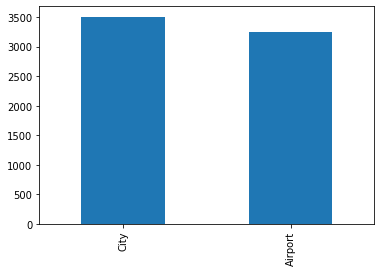

In [46]:
# Bar chart plot for 'Pickup_point' coloumn
df['Pickup_point'].value_counts().plot(kind='bar')

#### The distribution between city and airport is pretty fair and prevents biases from one point to another. 

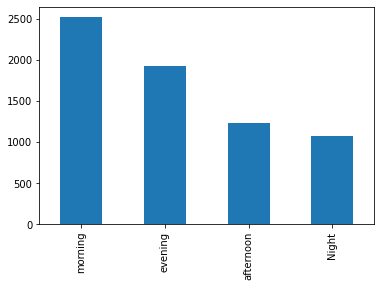

In [47]:
# Bar chart plot for 'Req_TOD' coloumn

df['Req_TOD'].value_counts().plot(kind='bar')

#### The plot shows the distribution of the trips during the day. Typically, the number of trips in the morning will surpass the number of night trips.

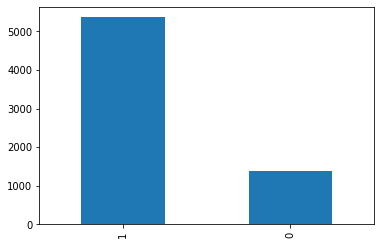

In [48]:
# Bar chart plot for 'Pickup_point' coloumn
df['is_weekday'].value_counts().plot(kind='bar')

#### The plot shows the distribution of the trips on weekdays (1) and weekends (0). Typically, the number of trips on weekdays will always surpass the weekends due to more weekdays than weekends. 

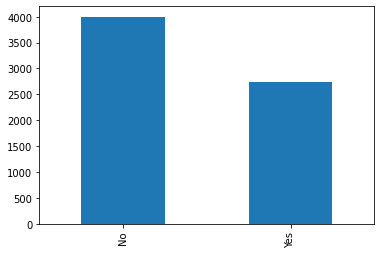

In [49]:
df['is_rushhour'].value_counts().plot(kind='bar')

#### The plot shows the distribution of the trips during rush hour or not. The distribution is fair and will help prevent any biases in the model prediction.

In [50]:
df.describe()

,mapped_status_type,is_weekday
count,6745.000000,6745.000000
mean,0.419718,0.795256
std,0.493549,0.403545
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


#### Outlier - Central Tendancy - Distribution 

In [51]:
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time,is_rushhour
0,Airport,Trip Completed,1,11/07/2016,1,11:51,morning,11/07/2016,13:00,No
1,Airport,Trip Completed,1,11/07/2016,1,17:57,afternoon,11/07/2016,18:47,Yes
2,City,Trip Completed,1,12/07/2016,1,09:17,morning,12/07/2016,9:58,Yes
3,Airport,Trip Completed,1,12/07/2016,1,21:08,evening,12/07/2016,22:03,No
4,City,Trip Completed,1,07/13/2016,1,08:33,morning,07/13/2016,09:25,Yes


In [52]:
df.dtypes

Pickup_point          object
Status                object
mapped_status_type     int64
Req_Date              object
is_weekday             int64
Req_Time              object
Req_TOD               object
Drop_Date             object
Drop_Time             object
is_rushhour           object
dtype: object

In [53]:
df.shape

(6745, 10)

## Machine Learning Models

### SVM

In [54]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

In [55]:
# LabelEncoder
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
        
        col_values = list(df[col].values)
        
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed

In [56]:
# define X and y
X = df[['is_rushhour', 'is_weekday', 'Pickup_point', 'Req_TOD']]
label_encode(X, X.columns.values)

y = df[['mapped_status_type']]
label_encode(y, y.columns.values)

<ipython-input-55-1a0856183423>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = col_values_transformed


In [57]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [58]:
# instantiate model
model = svm.SVC()

# fit model
model.fit(X_train, y_train)

/opt/tljh/user/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

In [59]:
# make class predictions for the testing set
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.720533728687917
0.6840192006659609


### Random Forest

In [65]:
# import library
from sklearn.ensemble import RandomForestClassifier

# define X and y
XRF = df[['is_rushhour', 'is_weekday', 'Pickup_point', 'Req_TOD']]
label_encode(XRF, XRF.columns.values)

yRF = df[['mapped_status_type']]
label_encode(yRF, yRF.columns.values)

# split X and y into training and testing sets
XRF_train, XRF_test, yRF_train, yRF_test = train_test_split(XRF, yRF, test_size = 0.20, random_state = 1)

# instantiate model
modelRF = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
modelRF.fit(XRF_train, yRF_train)

# make estimations for the testing set
yRF_pred = modelRF.predict(XRF_test)
yRF_pred

<ipython-input-55-1a0856183423>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = col_values_transformed
<ipython-input-65-2c5e56ce44fe>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelRF.fit(XRF_train, yRF_train)


array([0, 0, 0, ..., 1, 1, 0])

In [66]:
features = XRF.columns
print(features)
importances = modelRF.feature_importances_
print(importances)

Index(['is_rushhour', 'is_weekday', 'Pickup_point', 'Req_TOD'], dtype='object')
[0.04214006 0.02623752 0.38712218 0.54450024]


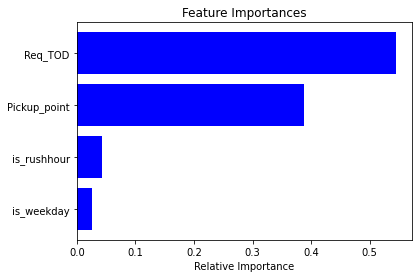

In [67]:
indices = np.argsort(importances)[-4:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [68]:
# fit model
modelRF.fit(XRF_train, yRF_train)
yRF_pred = modelRF.predict(XRF_test)
from sklearn import metrics
print(metrics.accuracy_score(yRF_test, yRF_pred))
print(metrics.roc_auc_score(yRF_test, yRF_pred))

<ipython-input-68-2bb4e09a911c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelRF.fit(XRF_train, yRF_train)


0.720533728687917
0.6840192006659609
